Merged 15 frames across 3 topics, total points: 1258282


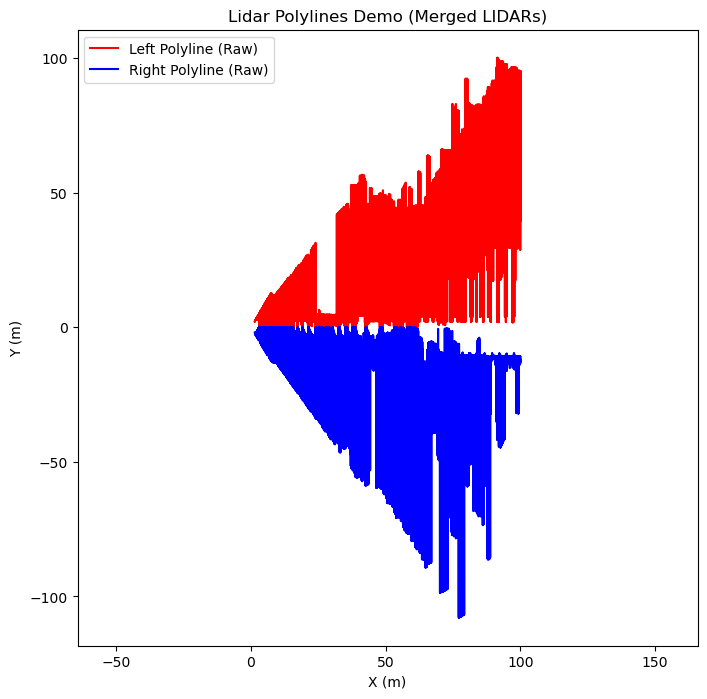

/tmp/ipykernel_7726/2517261332.py:73: RankWarning: Polyfit may be poorly conditioned
  coeffs_left = np.polyfit(left_line[:,0], left_line[:,1], deg=POLY_DEGREE)
/tmp/ipykernel_7726/2517261332.py:74: RankWarning: Polyfit may be poorly conditioned
  coeffs_right = np.polyfit(right_line[:,0], right_line[:,1], deg=POLY_DEGREE)


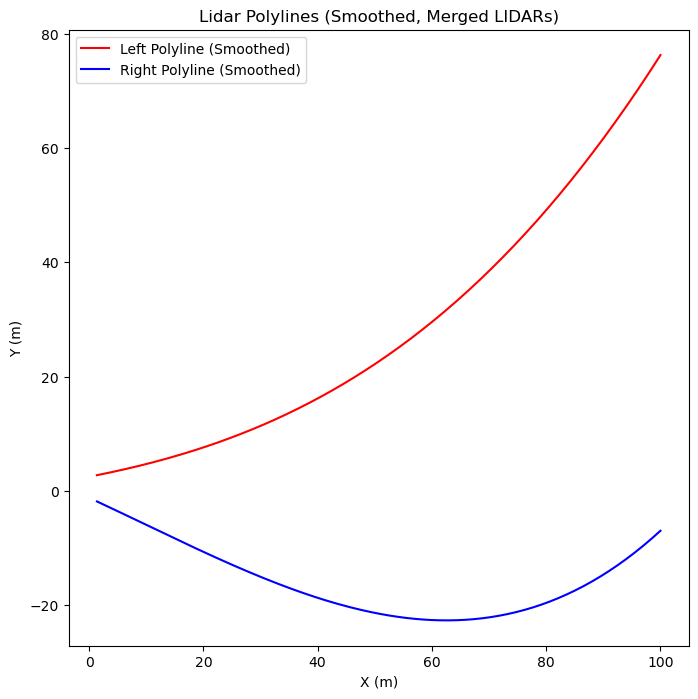

In [1]:
import rosbag2_py
from sensor_msgs.msg import PointCloud2
from sensor_msgs_py import point_cloud2
from rclpy.serialization import deserialize_message
import numpy as np
import matplotlib.pyplot as plt

# --- CONSTS---
MCAP_PATH = "/home/amrskk/.rviz2/intern_practice_ds.mcap" #Change to your mcap file path
TOPICS = [
    "/sensor/lidar_front/points",
    "/sensor/lidar_left/points",
    "/sensor/lidar_right/points"
]
NUM_FRAMES = 5           # how many frames to merge PER TOPIC
DISTANCE_LIMIT = 100.0   # max X distance to include (meters)
POLY_DEGREE = 3          # degree of polynomial fit

# --- 1. Opening MCAP reader ---
storage_options = rosbag2_py.StorageOptions(uri=MCAP_PATH, storage_id="mcap")
converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")

reader = rosbag2_py.SequentialReader()
reader.open(storage_options, converter_options)

# --- 2. Collecting frames from ALL topics ---
points_all = []

while reader.has_next():
    topic, data, t = reader.read_next()

    # Only process topics in our list
    if topic in TOPICS:
        msg = deserialize_message(data, PointCloud2)
        frame_points = np.array(
            [(p[0], p[1], p[2]) for p in point_cloud2.read_points(msg, field_names=("x","y","z"), skip_nans=True)],
            dtype=np.float32
        )
        points_all.append(frame_points)

        # Stop after we have NUM_FRAMES from *each* topic (approximation: total frames = NUM_FRAMES * number of topics)
        if len(points_all) >= NUM_FRAMES * len(TOPICS):
            break

# Merge frames from all topics
points = np.vstack(points_all)
print(f"Merged {len(points_all)} frames across {len(TOPICS)} topics, total points: {points.shape[0]}")

# --- 3. Filter by X distance ---
mask = (points[:, 0] > 0) & (points[:, 0] < DISTANCE_LIMIT)
xy_points = points[mask][:, :2]

# --- 4. Split into left/right polylines ---
left_line = xy_points[xy_points[:, 1] > 0]
right_line = xy_points[xy_points[:, 1] <= 0]

# Sort for polyfit
left_line = left_line[left_line[:, 0].argsort()]
right_line = right_line[right_line[:, 0].argsort()]

# --- 5. Plot raw polylines ---
plt.figure(figsize=(8, 8))
plt.plot(left_line[:, 0], left_line[:, 1], '-r', label="Left Polyline (Raw)")
plt.plot(right_line[:, 0], right_line[:, 1], '-b', label="Right Polyline (Raw)")
plt.axis("equal")
plt.legend()
plt.title("Lidar Polylines Demo (Merged LIDARs)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

# --- 6. Fit polynomial curves ---
coeffs_left = np.polyfit(left_line[:,0], left_line[:,1], deg=POLY_DEGREE)
coeffs_right = np.polyfit(right_line[:,0], right_line[:,1], deg=POLY_DEGREE)

poly_left = np.poly1d(coeffs_left)
poly_right = np.poly1d(coeffs_right)

# Generate smoothed X range
x_left = np.linspace(left_line[:,0].min(), left_line[:,0].max(), 200)
x_right = np.linspace(right_line[:,0].min(), right_line[:,0].max(), 200)

# --- 7. Plot smoothed polylines ---
plt.figure(figsize=(8,8))
plt.plot(x_left, poly_left(x_left), 'r-', label="Left Polyline (Smoothed)")
plt.plot(x_right, poly_right(x_right), 'b-', label="Right Polyline (Smoothed)")
plt.axis("equal")
plt.legend()
plt.title("Lidar Polylines (Smoothed, Merged LIDARs)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()
